In [1]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2, VarianceThreshold, RFE
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import resample

### `Load data numerical, categorical and target`

In [2]:
numericals = pd.read_csv('data/numerical.csv')
categoricals = pd.read_csv('data/categorical.csv')
targets = pd.read_csv('data/target.csv')

print(f"Numericals shape: {numericals.shape}")
print(f"Categoricals shape: {categoricals.shape}")
print(f"Targets shape: {targets.shape}")

Numericals shape: (95412, 315)
Categoricals shape: (95412, 22)
Targets shape: (95412, 2)


In [3]:
numericals_with_nan = [col for col in numericals.columns if numericals[col].isna().sum() > 0]
categoricals_with_nan = [col for col in categoricals.columns if categoricals[col].isna().sum() > 0]
targets_with_nan = [col for col in targets.columns if targets[col].isna().sum() > 0]

print(f"There are '{len(numericals_with_nan)}' NaN columns in Numericals.")
print(f"There are '{len(categoricals_with_nan)}' NaN columns in Categoricals.")
print(f"There are '{len(targets_with_nan)}' NaN columns in Targets.")

There are '0' NaN columns in Numericals.
There are '1' NaN columns in Categoricals.
There are '0' NaN columns in Targets.


In [4]:
categoricals.dropna(subset=categoricals_with_nan, inplace=True)
categoricals[categoricals_with_nan].value_counts(dropna=False)

FIRSTDATE_MM
1.0             18175
9.0             15196
10.0            14540
2.0             12839
3.0              6813
11.0             6572
12.0             5981
4.0              4267
6.0              3356
8.0              3008
7.0              2846
5.0              1817
dtype: int64

In [5]:
important_columns = ['WEALTH1', 'WEALTH2', 'VETERANS', 'SOLIH']

### `Numericals - Variance Threshold`

In [38]:
min_max_scaler = MinMaxScaler()
numericals_scaled = min_max_scaler.fit_transform(numericals)

In [6]:
selector = VarianceThreshold(0.09)
selected_numericals = selector.fit_transform(numericals_scaled)

columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, selector.get_support()) if col_tuple[1] == False]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '293' columns to drop.


In [7]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_variance = numericals.drop(columns_to_drop, axis=1)
numericals_variance.shape

(95412, 22)

In [8]:
def display_heatmap(dataframe):
    corr=dataframe.corr()

    mask=np.triu(np.ones_like(corr, dtype=bool))     # generate a mask for the upper triangle

    f, ax=plt.subplots(figsize=(11, 9))                 # set up the matplotlib figure

    cmap=sns.diverging_palette(220, 10, as_cmap=True)   # generate a custom diverging colormap

    sns.heatmap(corr, mask=mask, cmap=cmap,             # draw the heatmap with the mask and correct aspect ratio
                vmax=.3, center=0, square=True,
                linewidths=.5, cbar_kws={"shrink": .5})

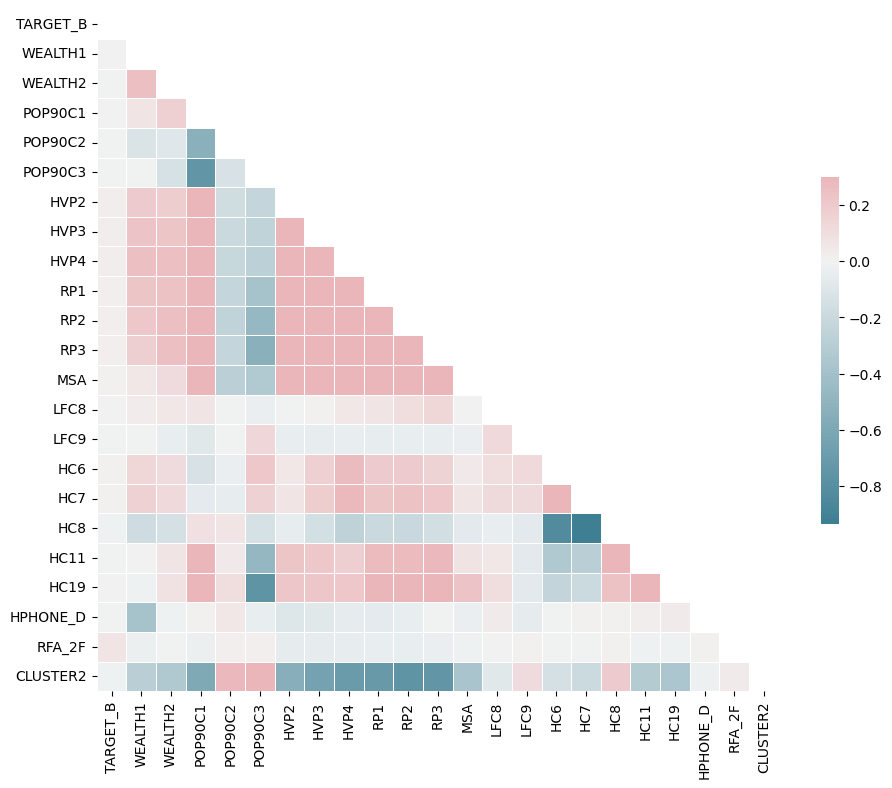

In [9]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_variance], axis=1))

In [10]:
numericals_variance_manual_drop = numericals_variance.drop(['POP90C3', 'HC6', 'HC7', 'CLUSTER2'], axis=1)
numericals_variance_manual_drop.shape

(95412, 18)

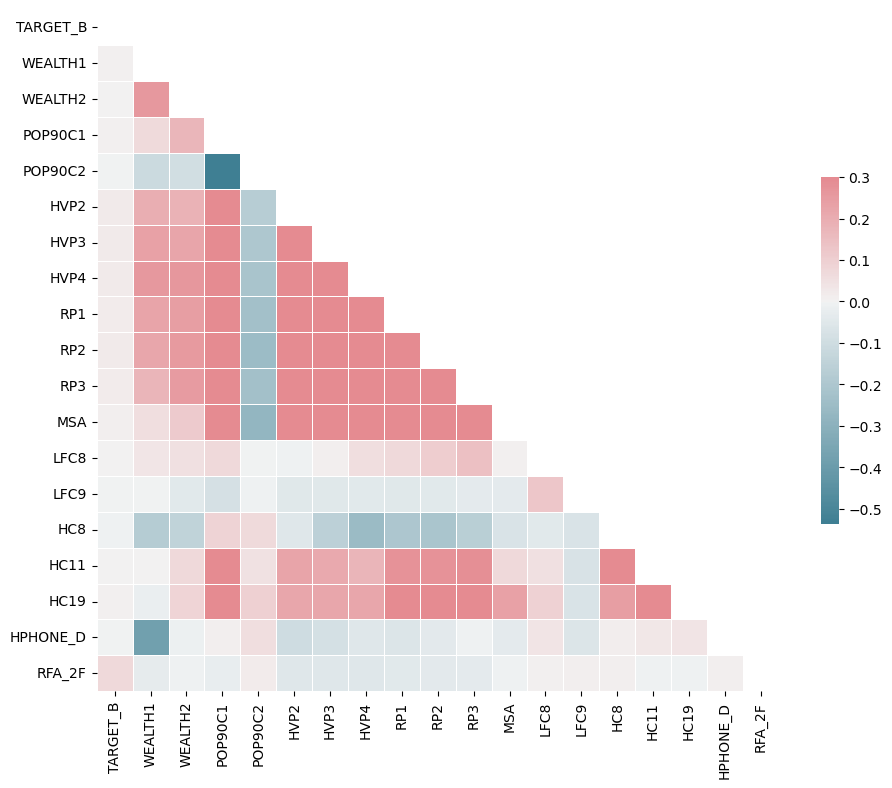

In [11]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_variance_manual_drop], axis=1))

### `Numericals - Chi2`

In [12]:
selector = SelectKBest(chi2, k=10)
selector.fit(numericals_scaled, targets[['TARGET_B']])
mask = selector.get_support()
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '305' columns to drop.


In [13]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_chi2 = numericals.drop(columns_to_drop, axis=1)
numericals_chi2.shape

(95412, 12)

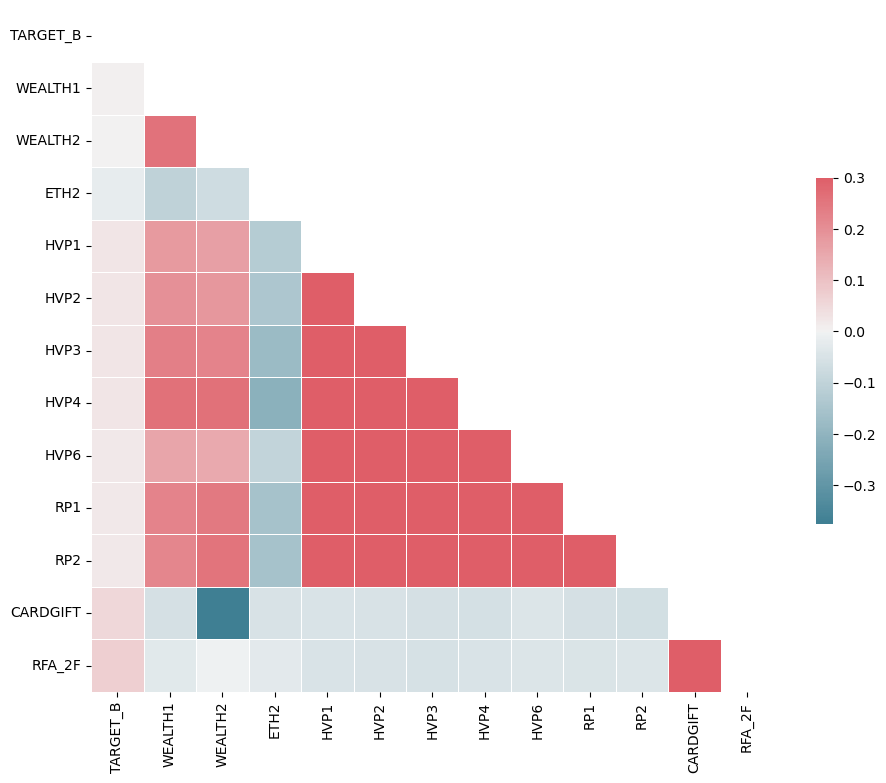

In [14]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_chi2], axis=1))

### `Numericals - RFE`

In [15]:
model = LinearRegression()

# Create an instance of the RFE class
rfe = RFE(model, n_features_to_select=25, verbose=False)

# Fit the RFE to the DataFrame
rfe.fit(numericals_scaled, targets[['TARGET_B']])

# Get the boolean mask of the selected columns
mask = rfe.support_

# Use the mask to obtain the names of the selected columns
columns_to_drop = numericals.columns[~mask]

print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '290' columns to drop.


In [16]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_rfe = numericals.drop(columns_to_drop, axis=1)
numericals_rfe.shape

(95412, 27)

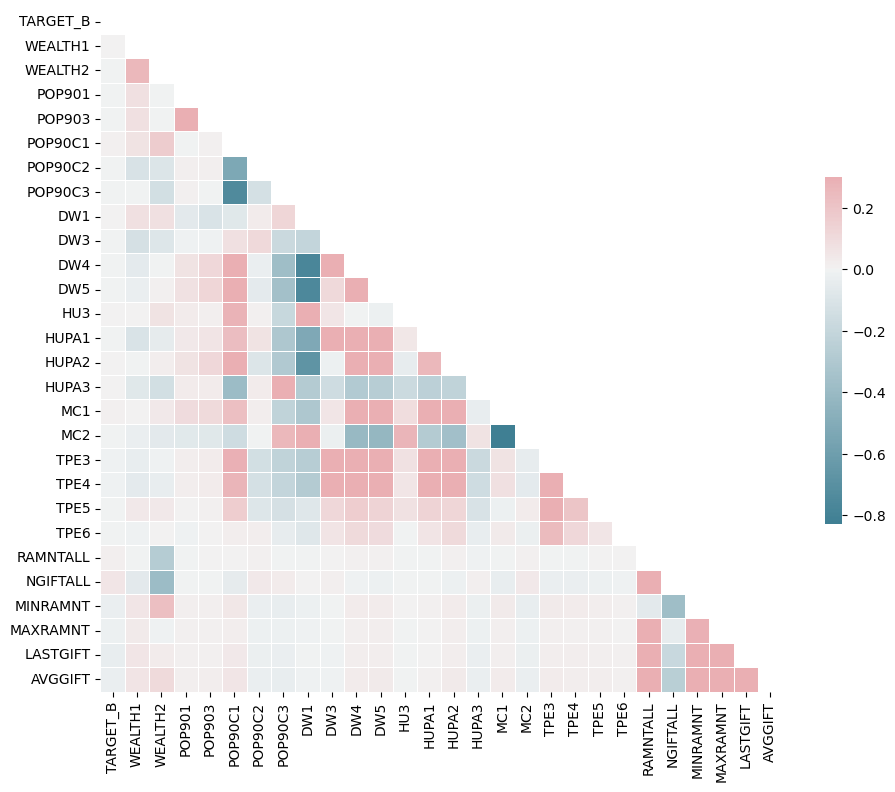

In [17]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_rfe], axis=1))

In [18]:
numericals_rfe_manual_drop = numericals_rfe.drop(['POP90C1', 'DW1', 'MC2'], axis=1)
numericals_rfe_manual_drop.shape

(95412, 24)

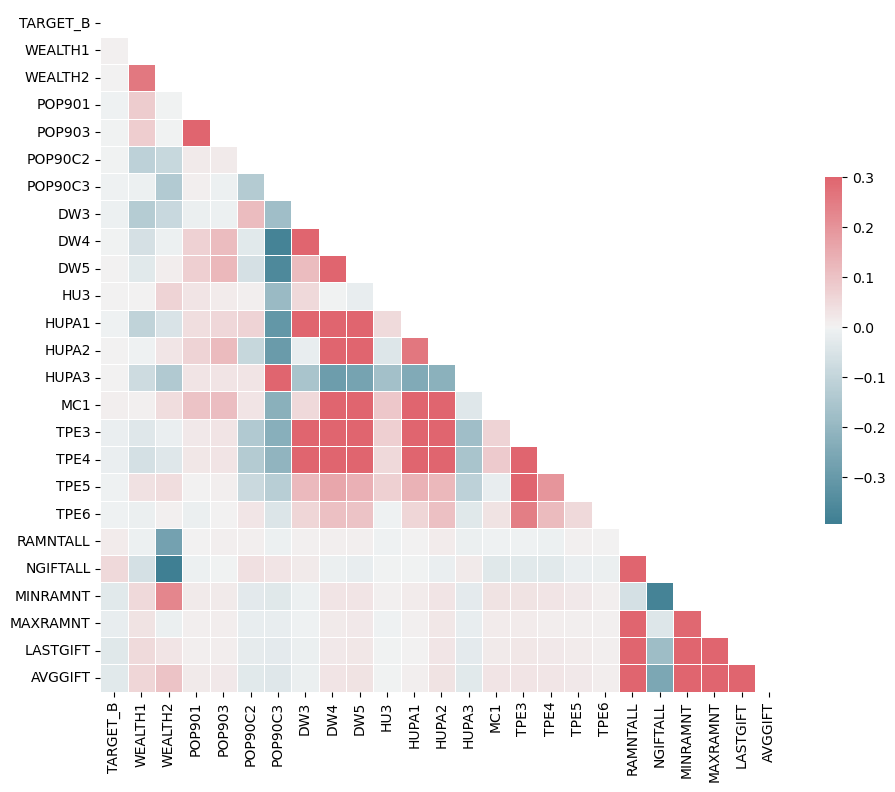

In [19]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_rfe_manual_drop], axis=1))

### `Numericals - OLS`

In [20]:
df = sm.add_constant(numericals_scaled)

# Fit the OLS model
model = sm.OLS(targets[['TARGET_B']], df)
results = model.fit()

# Get the p-values of the features
pvalues = results.pvalues

# Select the features with a p-value more than 0.05
columns_to_drop = [col_tuple[0] for col_tuple in zip(numericals.columns, pvalues[1::]) if col_tuple[1] > 0.05]
print(f"There are '{len(columns_to_drop)}' columns to drop.")

There are '293' columns to drop.


In [21]:
columns_to_drop = [col for col in columns_to_drop if col not in important_columns]
numericals_ols = numericals.drop(columns_to_drop, axis=1)
numericals_ols.shape

(95412, 23)

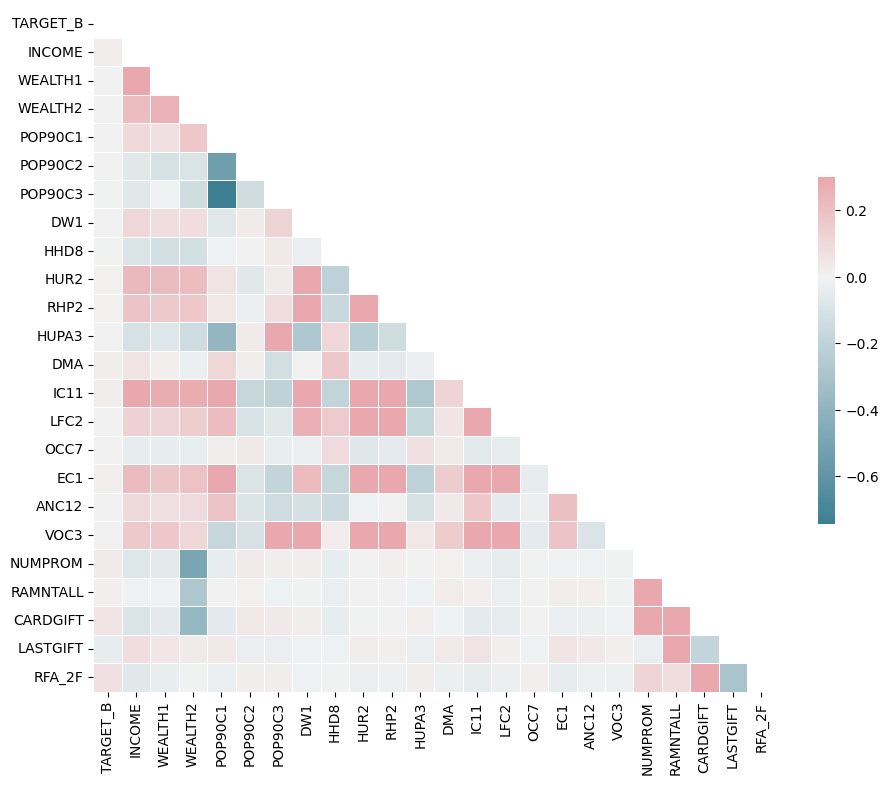

In [22]:
display_heatmap(pd.concat([targets[['TARGET_B']], numericals_ols], axis=1))

### `Categoricals`

In [23]:
categoricals.nunique()

STATE           12
CLUSTER         53
HOMEOWNR         2
GENDER           3
DATASRCE         3
RFA_2R           1
RFA_2A           4
GEOCODE2         4
DOMAIN_A         5
DOMAIN_B         4
ODATEW_YR       15
ODATEW_MM       12
DOB_YR          96
DOB_MM          12
MINRDATE_YR     20
MINRDATE_MM     12
MAXRDATE_YR     18
MAXRDATE_MM     12
LASTDATE_YR      3
LASTDATE_MM     12
FIRSTDATE_YR    25
FIRSTDATE_MM    12
dtype: int64

In [24]:
categoricals.dtypes

STATE            object
CLUSTER           int64
HOMEOWNR         object
GENDER           object
DATASRCE          int64
RFA_2R           object
RFA_2A           object
GEOCODE2         object
DOMAIN_A         object
DOMAIN_B          int64
ODATEW_YR         int64
ODATEW_MM         int64
DOB_YR            int64
DOB_MM            int64
MINRDATE_YR       int64
MINRDATE_MM       int64
MAXRDATE_YR       int64
MAXRDATE_MM       int64
LASTDATE_YR       int64
LASTDATE_MM       int64
FIRSTDATE_YR      int64
FIRSTDATE_MM    float64
dtype: object

In [25]:
object_columns_from_categoricals = [col for col in categoricals.columns if categoricals[col].dtype == object]

In [26]:
for col in object_columns_from_categoricals:
    categoricals[col] = pd.factorize(categoricals[col])[0]

In [27]:
# 'RFA_2R' has only 1 unique value so we can drop it

categoricals.drop('RFA_2R', axis=1, inplace=True)
categoricals.shape

(95410, 21)

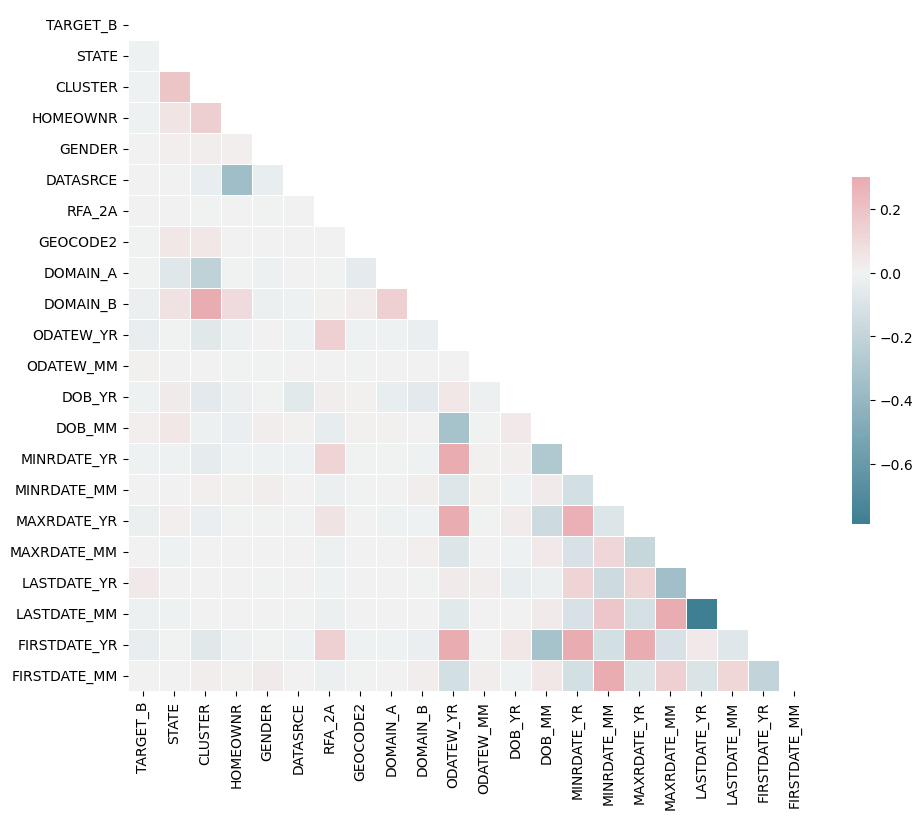

In [28]:
# Check correlation matrix on categorical features

display_heatmap(pd.concat([targets[['TARGET_B']], categoricals], axis=1))

### `Check accuracy with sets of selected columns`

In [29]:
def get_full_dfs_tuples(targets, selected_numericals_df_tuples):
    return [
        (sub_df[0], pd.concat([targets, sub_df[1], categoricals], axis=1).dropna(axis=0).dropna(axis=1))
            for sub_df in selected_numericals_df_tuples
    ]

def score_selected_columns(targets, selected_numericals_df_list):
    index = 1
    df_tuples = get_full_dfs_tuples(targets, selected_numericals_df_list)
    for tuple in df_tuples:

        print("================================")
        print(f"{tuple[0]}")

        y = tuple[1]['TARGET_B']
        X = tuple[1].drop('TARGET_B', axis=1)
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

        # Scaling data = X_train
        X_train_transformer = MinMaxScaler().fit(X_train)
        X_train_normalized = X_train_transformer.transform(X_train)
        X_train_normalized = pd.DataFrame(X_train_normalized)

        # Scaling data = X_test
        X_test_transformer = MinMaxScaler().fit(X_test)
        X_test_normalized = X_test_transformer.transform(X_test)
        X_test_normalized = pd.DataFrame(X_test_normalized)

        # Create an instance of the DecisionTreeClassifier
        clf = DecisionTreeClassifier()

        # Fit the classifier to the training data
        clf.fit(X_train_normalized, y_train)

        # Make predictions on the test data
        y_pred = clf.predict(X_test_normalized)

        # Calculate the accuracy of the model
        display(confusion_matrix(y_test, y_pred))

        scores = cross_val_score(clf, X_train_normalized, y_train, cv=10)
        # Print the mean and standard deviation of the scores
        print("Accuracy: %0.2f (+/- %0.2f)" % (scores.mean(), scores.std() * 2))
        
        accuracy = accuracy_score(y_test, y_pred)
        print(f"accuracy: {accuracy}")
        print("precision: ",precision_score(y_test, y_pred))
        print("recall: ",recall_score(y_test, y_pred))
        print("f1: ",f1_score(y_test, y_pred))

        print("================================")

        index += 1

In [30]:
selected_numericals_df_list = [
    ('numericals', numericals), 
    ('numericals_variance', numericals_variance), 
    ('numericals_variance_manual_drop', numericals_variance_manual_drop),
    ('numericals_chi2', numericals_chi2),
    ('numericals_rfe', numericals_rfe),
    ('numericals_rfe_manual_drop', numericals_rfe_manual_drop),
    ('numericals_ols', numericals_ols)
]

score_selected_columns(targets[['TARGET_B']], selected_numericals_df_list)

numericals


array([[11424,  6707],
       [  641,   310]])

Accuracy: 0.89 (+/- 0.01)
accuracy: 0.6149250602662195
precision:  0.04417842382784666
recall:  0.32597266035751843
f1:  0.07781124497991969
numericals_variance


array([[15656,  2443],
       [  828,   155]])

Accuracy: 0.89 (+/- 0.01)
accuracy: 0.8285819096530762
precision:  0.059661277906081604
recall:  0.15768056968463887
f1:  0.08656799776598716
numericals_variance_manual_drop


array([[15886,  2271],
       [  760,   165]])

Accuracy: 0.89 (+/- 0.01)
accuracy: 0.8411592076302274
precision:  0.06773399014778325
recall:  0.1783783783783784
f1:  0.09818506396905682
numericals_chi2


array([[16422,  1643],
       [  926,    91]])

Accuracy: 0.89 (+/- 0.01)
accuracy: 0.8653705062362436
precision:  0.052479815455594
recall:  0.08947885939036382
f1:  0.06615776081424936
numericals_rfe


array([[ 5258, 12798],
       [  283,   743]])

Accuracy: 0.89 (+/- 0.00)
accuracy: 0.31448485483701916
precision:  0.054870393619378184
recall:  0.7241715399610137
f1:  0.10201139562023752
numericals_rfe_manual_drop


array([[15447,  2616],
       [  853,   166]])

Accuracy: 0.89 (+/- 0.00)
accuracy: 0.8182056388219264
precision:  0.05966930265995687
recall:  0.16290480863591755
f1:  0.08734543541173376
numericals_ols


array([[15784,  2382],
       [  766,   150]])

Accuracy: 0.89 (+/- 0.01)
accuracy: 0.8350277748663663
precision:  0.05924170616113744
recall:  0.16375545851528384
f1:  0.08700696055684455


### `Try imbalance Undersampling`

In [31]:
target_b = targets[['TARGET_B']]
target_b['TARGET_B'].value_counts()

target_b_0 = target_b[target_b['TARGET_B'] == 0]
target_b_1 = target_b[target_b['TARGET_B'] == 1]

target_b_0_undersampled = resample(target_b_0, replace=False, n_samples=len(target_b_1))
target_b_0_undersampled.shape

(4843, 1)

In [32]:
target_b_downsampled = pd.concat([target_b_0_undersampled, target_b_1], axis=0).sample(frac=1)
target_b_downsampled['TARGET_B'].value_counts()

0    4843
1    4843
Name: TARGET_B, dtype: int64

In [33]:
score_selected_columns(target_b_downsampled, selected_numericals_df_list)

numericals


array([[469, 494],
       [513, 462]])

Accuracy: 0.51 (+/- 0.03)
accuracy: 0.4803921568627451
precision:  0.48326359832635984
recall:  0.47384615384615386
f1:  0.4785085447954428
numericals_variance


array([[506, 458],
       [499, 475]])

Accuracy: 0.52 (+/- 0.03)
accuracy: 0.5061919504643962
precision:  0.5091103965702036
recall:  0.48767967145790553
f1:  0.4981646565285789
numericals_variance_manual_drop


array([[487, 476],
       [459, 516]])

Accuracy: 0.52 (+/- 0.04)
accuracy: 0.5175438596491229
precision:  0.5201612903225806
recall:  0.5292307692307693
f1:  0.5246568378240976
numericals_chi2


array([[544, 442],
       [442, 510]])

Accuracy: 0.52 (+/- 0.04)
accuracy: 0.543859649122807
precision:  0.5357142857142857
recall:  0.5357142857142857
f1:  0.5357142857142857
numericals_rfe


array([[571, 422],
       [510, 435]])

Accuracy: 0.53 (+/- 0.04)
accuracy: 0.5190918472652218
precision:  0.5075845974329055
recall:  0.4603174603174603
f1:  0.48279689234184237
numericals_rfe_manual_drop


array([[510, 435],
       [556, 437]])

Accuracy: 0.52 (+/- 0.03)
accuracy: 0.4886480908152735
precision:  0.5011467889908257
recall:  0.44008056394763345
f1:  0.4686327077747989
numericals_ols


array([[556, 422],
       [480, 480]])

Accuracy: 0.52 (+/- 0.02)
accuracy: 0.5345717234262126
precision:  0.532150776053215
recall:  0.5
f1:  0.5155746509129967


### `Try Oversampling`

In [34]:
target_b = targets[['TARGET_B']]
target_b['TARGET_B'].value_counts()

target_b_0 = target_b[target_b['TARGET_B'] == 0]
target_b_1 = target_b[target_b['TARGET_B'] == 1]

target_b_1_undersampled = resample(target_b_1, replace=True, n_samples=len(target_b_0))
target_b_1_undersampled.shape

(90569, 1)

In [35]:
target_b_oversampled = pd.concat([target_b_0, target_b_1_undersampled], axis=0).sample(frac=1)
target_b_oversampled['TARGET_B'].value_counts()

0    90569
1    90569
Name: TARGET_B, dtype: int64

In [36]:
score_selected_columns(target_b_oversampled, selected_numericals_df_list)

numericals


array([[17549,   691],
       [14775,  3213]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.5730926355305289
precision:  0.8230020491803278
recall:  0.1786190793862575
f1:  0.29353188379316647
numericals_variance


array([[16915,  1243],
       [ 4130, 13940]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.8516893010930772
precision:  0.9181321214516235
recall:  0.7714443829551744
f1:  0.8384205936306499
numericals_variance_manual_drop


array([[17077,  1018],
       [ 6824, 11309]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.7835375952302087
precision:  0.9174170519996755
recall:  0.6236695527491314
f1:  0.7425476034143138
numericals_chi2


array([[16944,  1123],
       [ 6324, 11837]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.7944407640499062
precision:  0.9133487654320988
recall:  0.6517812895765651
f1:  0.7607082034638989
numericals_rfe


array([[17103,  1082],
       [15254,  2789]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.5490780611681573
precision:  0.7204856626194782
recall:  0.1545751815108352
f1:  0.2545404764077759
numericals_rfe_manual_drop


array([[17267,   860],
       [15566,  2535]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.5465937948548084
precision:  0.7466863033873343
recall:  0.14004751118722722
f1:  0.2358578340156308
numericals_ols


array([[17068,  1059],
       [13360,  4741]])

Accuracy: 0.96 (+/- 0.00)
accuracy: 0.6019929336424865
precision:  0.8174137931034483
recall:  0.2619192309817137
f1:  0.3967198025187231


### `Comments`

In [37]:
# Columns selected in 'numericals_variance' with Oversampled 'TARGET_B' seems to give us better results.